# Load modules

In [2]:
import os
import pandas as pd
import json
import numpy as np

# Add all datas

## Create bbox df

In [3]:
def create_bbox_df(input_folder):
    df_list = []
    for txt_file in os.listdir(input_folder):
        # Construire le chemin complet du fichier texte
        txt_file_path = os.path.join(input_folder, txt_file)

        # Extraire l'ID du document à partir du nom du fichier sans extension
        doc_id = os.path.splitext(txt_file)[0]

        # Lire les lignes du fichier texte
        with open(txt_file_path, 'r', encoding='ISO-8859-1') as f:
            doc = f.readlines()
            # Vérifier si le fichier n'est pas vide et exclure les lignes qui ne contiennent que '\n'
            filtered_lines = [line.strip() for line in doc if line.strip()]
            for idx, line in enumerate(filtered_lines, start=1):
                line = str(line)
                line = ','.join(line.split(',')[8:])
                if line:
                    # Créer un DataFrame pour les lignes du fichier texte
                    df_lines = pd.DataFrame({'value': [line]})

                    # Ajouter les colonnes d'ID du document et d'ID de ligne
                    df_lines['doc'] = doc_id
                    df_lines['line_id'] = idx  # Utiliser l'index de la boucle comme ID de ligne

                    # Ajouter ce DataFrame à la liste
                    df_list.append(df_lines)

                    # Concaténer tous les DataFrames dans la liste en un seul DataFrame
    df = pd.concat(df_list, ignore_index=True)
    df['value'] = df['value'].str.split()
    # Utiliser explode pour créer une ligne pour chaque mot tout en conservant l'ID
    df =df.explode('value', ignore_index=True)
    return df

In [4]:
input_folder_train= '/home/e077926/buscode_2023/05_E2_tata/data/SROIE2019/train/box'
input_folder_test='/home/e077926/buscode_2023/05_E2_tata/data/SROIE2019/test/box'

bbox_values_df_train=create_bbox_df(input_folder_train)
bbox_values_df_test=create_bbox_df(input_folder_test)
bbox_values_df_train.head()

,value,doc,line_id
0,TAN,X00016469612,1
1,WOON,X00016469612,1
2,YANN,X00016469612,1
3,BOOK,X00016469612,2
4,TA,X00016469612,2


In [5]:
len(bbox_values_df_train)

72390

## Create labels df

In [6]:
def create_label_df(label_folder_path):
    label_df = pd.DataFrame(columns=['value', 'entity', 'doc'])
    # Parcourir les fichiers dans le dossier
    for entity_file in os.listdir(label_folder_path):
        file_name, _ = os.path.splitext(entity_file)
        file_path = os.path.join(label_folder_path, entity_file)

        # Charger le fichier JSON
        with open(file_path, 'r') as f:
            data_dict = json.load(f)

            # Parcourir les clés et valeurs du dictionnaire pour créer des lignes de DataFrame
            for k, v in data_dict.items():
                # Ajouter les clés et valeurs au DataFrame
                temp_df = pd.DataFrame({'value': [v], 'entity': [k], 'doc': [file_name]})
                label_df = pd.concat([label_df, temp_df], ignore_index=True)

    # Convertir la colonne 'value' au format string, si nécessaire
    label_df['value'] = label_df['value'].astype(str)
    label_df['value'] = label_df['value'].str.split()
# Utiliser explode pour créer une ligne pour chaque mot tout en conservant l'ID
    label_df =label_df.explode('value', ignore_index=True)
    return label_df

In [7]:
label_folder_path_train = "/home/e077926/buscode_2023/05_E2_tata/data/SROIE2019/train/entities/"
label_folder_path_test = "/home/e077926/buscode_2023/05_E2_tata/data/SROIE2019/test/entities"

bbox_labels_df_train=create_label_df(label_folder_path_train)
bbox_labels_df_test=create_label_df(label_folder_path_test)

In [8]:
bbox_labels_df_test

,value,entity,doc
0,OJC,company,X00016469670
1,MARKETING,company,X00016469670
2,SDN,company,X00016469670
3,BHD,company,X00016469670
4,15/01/2019,date,X00016469670
...,...,...,...
6077,56100,address,X51009568881
6078,"CHERAS,",address,X51009568881
6079,KUALA,address,X51009568881
6080,LUMPUR.,address,X51009568881


# Bios Datas with b-box

## Bold ner df

In [9]:
def add_bold_entities(id_df, label_df):

    new_df = pd.merge(id_df, label_df,  how='left', on = ['doc','value'])
    new_df = new_df.reindex(columns=["doc", "line_id", "value", "entity"])
    grouped_counts= new_df.groupby(['doc', 'line_id', 'entity']).size().reset_index(name='count')
    grouped_counts['max'] = grouped_counts.groupby(['doc', 'line_id'])['count'].transform('max')
    temp_df=new_df.merge(grouped_counts, how='left', on=['doc', 'line_id', 'entity'])
    temp_df.drop(temp_df[temp_df['count']< temp_df['max']].index, inplace = True)
    temp_df['is_duplicate'] = temp_df.duplicated(subset=['doc', 'line_id', 'value'], keep=False)

    # Filtrer pour garder uniquement les lignes qui sont des doublons
    duplicates = temp_df[temp_df['is_duplicate']]

    # Filtrer les doublons pour garder seulement ceux dont 'entity' n'apparaît pas déjà dans le même 'doc'
    filtered_duplicates = duplicates[~duplicates['entity'].isin(duplicates.groupby(['doc', 'value'])['entity'].transform('first'))]

    # Concaténer les lignes à garder avec les lignes qui ne sont pas des doublons
    result_df = pd.concat([temp_df[~temp_df['is_duplicate']], filtered_duplicates])

    # Supprimer la colonne temporaire
    result_df = result_df.drop(columns=['is_duplicate'])
    O_df=result_df.copy()
    O_df['entity'] = O_df['entity'].fillna('O')
    # Créer une nouvelle colonne pour les entités avec les suffixes
    BIO_df=O_df.copy().reset_index()
    bold_entity_df=BIO_df.drop(columns=['count','max', 'index'])
    return bold_entity_df

In [10]:
bold_df_train=add_bold_entities(bbox_values_df_train,bbox_labels_df_train)
bold_df_test=add_bold_entities(bbox_values_df_test,bbox_labels_df_test)

In [11]:
bold_df_train

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,company
4,X00016469612,2,TA,company
...,...,...,...,...
71715,X51008164997,51,****,O
71716,X51008164998,48,****,O
71717,X51008164998,48,****,O
71718,X51008164999,65,****,O


In [12]:
bold_df_test

,doc,line_id,value,entity
0,X00016469670,1,TAN,O
1,X00016469670,1,CHAY,O
2,X00016469670,1,YEE,O
3,X00016469670,2,COPY,O
4,X00016469670,3,OJC,company
...,...,...,...,...
39400,X51008099100,7,0,O
39401,X51008099100,7,0,O
39402,X51008099100,7,0,O
39403,X51009447842,14,AMT,O


## BIO df

In [13]:
def add_bio(BIO_df):
    # Initialiser un dictionnaire pour suivre les premières occurrences d'entités par document
    first_occurrence = {}
    
    for i in range(len(BIO_df)):
        doc = BIO_df.at[i, 'doc']
        entity = BIO_df.at[i, 'entity']
        
        # Ignorer les entités 'O'
        if entity == 'O':
            continue
        
        # Vérifier si l'entité a déjà été rencontrée dans ce document
        if doc not in first_occurrence:
            first_occurrence[doc] = {entity: True}  # Première occurrence de cette entité dans ce document
            prefix = 'B-'
        else:
            # Si l'entité n'est pas dans le dictionnaire, c'est sa première occurrence
            if entity not in first_occurrence[doc]:
                first_occurrence[doc][entity] = True
                prefix = 'B-'
            else:
                prefix = 'I-'
        
        BIO_df.at[i, 'entity'] = prefix + entity
    
    return BIO_df

In [14]:
bio_df_test=add_bio(bold_df_test)
bio_df_train=add_bio(bold_df_train)

In [15]:
bio_df_train.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company


In [16]:
len(bio_df_train)

71720

## Concat DFs

In [17]:
bio_df=pd.concat([bio_df_train, bio_df_test], ignore_index=True)

# Graphic View

In [18]:
bio_df

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company
...,...,...,...,...
111120,X51008099100,7,0,O
111121,X51008099100,7,0,O
111122,X51008099100,7,0,O
111123,X51009447842,14,AMT,O


<Axes: xlabel='entity'>

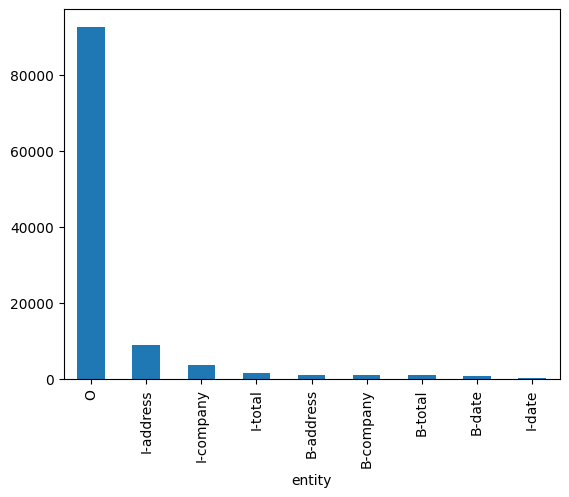

In [19]:
bio_repartition=bio_df['entity']
bio_repartition.value_counts().plot(kind= 'bar')

<Axes: xlabel='entity'>

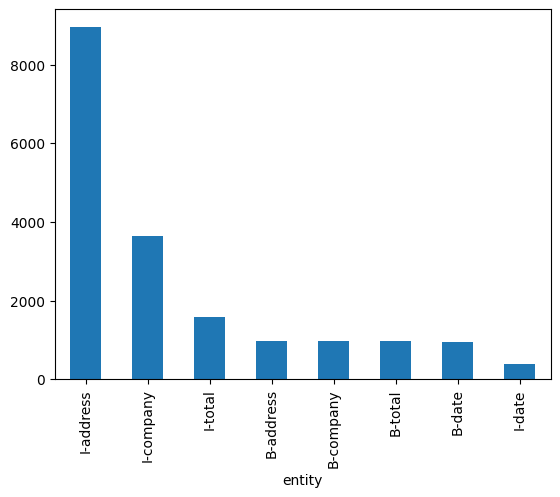

In [20]:
bio_repartition_noo=bio_df[bio_df['entity'] != "O"].reset_index()
bio_repartition_noo=bio_repartition_noo['entity']
bio_repartition_noo.value_counts().plot(kind= 'bar')

# Check at Dates and Total

In [21]:
bio_df[bio_df['entity'] == 'B-address']

,doc,line_id,value,entity
10,X00016469612,4,NO.53,B-address
94,X00016469619,3,DEDAP,B-address
192,X00016469620,4,LOT,B-address
310,X00016469622,4,NO,B-address
421,X00016469623,4,LOT,B-address
...,...,...,...,...
110305,X51008099100,2,NO.19,B-address
110428,X51009008095,2,"12,",B-address
110527,X51009447842,4,NO,B-address
110616,X51009453729,4,NO.32,B-address


In [22]:
groups = bio_df['doc'].value_counts()
groups


doc
X51006619545    240
X51005663297    233
X51005433533    221
X51005705760    218
X51006389963    212
               ... 
X51006619509     54
X51005442388     54
X51006008197     53
X51008164510     43
X51005442341     25
Name: count, Length: 973, dtype: int64

### Totaux

In [23]:
bio_df[bio_df['entity'] == 'B-total']

,doc,line_id,value,entity
54,X00016469612,28,9.00,B-total
149,X00016469619,39,60.30,B-total
276,X00016469620,44,33.90,B-total
379,X00016469622,43,80.90,B-total
523,X00016469623,51,30.90,B-total
...,...,...,...,...
110390,X51008099100,38,46.90,B-total
110471,X51009008095,18,31.80,B-total
110563,X51009447842,21,0.90,B-total
110678,X51009453729,26,79.50,B-total


### Regarder les totaux en doublon

In [24]:
# Étape 1: Filtrer pour obtenir uniquement les lignes avec 'B-total' et 'I-total'
filtered_df = bio_df[bio_df['entity'].isin(['B-total', 'I-total'])]
# Étape 2: Grouper par 'doc', 'line_id', 'entity' et compter le nombre d'occurrences
grouped_totals = filtered_df.groupby(['doc', 'line_id', 'entity', 'value']).size().reset_index(name='count')
grouped_totals

,doc,line_id,entity,value,count
0,X00016469612,28,B-total,9.00,1
1,X00016469612,33,I-total,9.00,1
2,X00016469612,44,I-total,9.00,1
3,X00016469619,39,B-total,60.30,1
4,X00016469620,44,B-total,33.90,1
...,...,...,...,...,...
2550,X51009568881,28,B-total,10.40,1
2551,X51009568881,34,I-total,10.40,1
2552,X51009568881,36,I-total,10.40,1
2553,X51009568881,47,I-total,10.40,1


In [25]:
# Créer un dictionnaire pour mémoriser les valeurs de 'B-total' par 'doc'
b_total_values = {}

# Itérer sur chaque ligne pour remplir le dictionnaire avec les valeurs de 'B-total'
for index, row in bio_df.iterrows():
    if row['entity'] == 'B-total':
        if row['doc'] not in b_total_values:
            b_total_values[row['doc']] = set()  # Utiliser un set pour éviter les duplicatas
        b_total_values[row['doc']].add(row['value'])  # Ajouter la valeur à l'ensemble

In [26]:
# Étape 1: Obtenir tous les documents uniques dans le DataFrame
all_docs = set(bio_df['doc'].unique())

# Étape 2: Obtenir les documents ayant des entités 'B-total' à partir de votre dictionnaire
docs_with_b_total = set(b_total_values.keys())

# Étape 3: Trouver la différence entre les deux ensembles pour identifier les documents sans 'B-total'
docs_without_b_total = all_docs - docs_with_b_total

print("Documents sans 'B-total':")
print(docs_without_b_total)


Documents sans 'B-total':
{'X51005433522', 'X51007339106', 'X51006466060', 'X51005764154', 'X51005806678', 'X51006733495', 'X51005684949'}


Drop wrong labelized total

In [27]:
# Filtrer bio_df pour exclure les lignes correspondant aux documents sans 'B-total'
bio_df= bio_df[~bio_df['doc'].isin(docs_without_b_total)]
bio_df.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company


In [28]:
len(bio_df)

110455

Enlever les totaux en doublon 

In [29]:
# Itérer de nouveau sur le DataFrame pour identifier et remplacer les 'I-total' correspondants
for index, row in bio_df.iterrows():
    if row['entity'] == 'I-total' and row['doc'] in b_total_values:
        if row['value'] in b_total_values[row['doc']]:
            bio_df.at[index, 'entity'] = 'O'  # Remplacer l'entité par 'O'

In [30]:
len(bio_df)

110455

entity
I-address    8894
I-company    3618
B-total       966
B-address     965
B-company     961
B-date        940
I-date        375
I-total        53
Name: count, dtype: int64


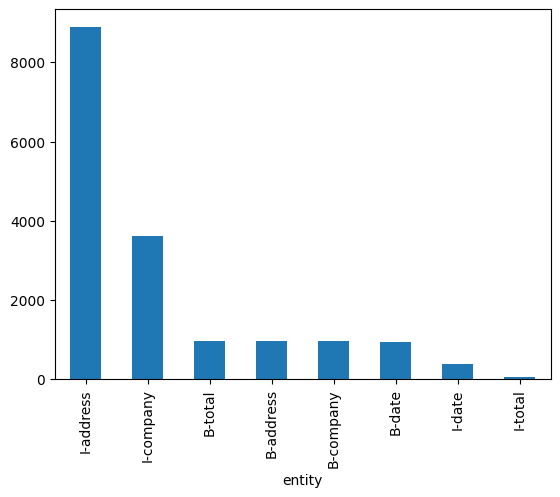

In [31]:
def check_entities(bio_df):
    bio_repartition_noo=bio_df[bio_df['entity'] != "O"].reset_index()
    bio_repartition_noo=bio_repartition_noo['entity']
    bio_repartition_noo.value_counts().plot(kind= 'bar')
    print(bio_repartition_noo.value_counts())

check_entities(bio_df)

In [32]:
i_total_rows = bio_df[bio_df['entity'] == 'I-total']
i_total_rows.head()

,doc,line_id,value,entity
8767,X51005568884,20,RM,I-total
8770,X51005568884,22,RM,I-total
8773,X51005568884,24,RM,I-total
17153,X51005719814,39,29.70,I-total
17161,X51005719814,43,29.70,I-total


drop touts les totaux avec RM

In [33]:
# Appliquer le filtre correctement pour exclure les lignes spécifiques
bio_df = bio_df[~((bio_df['entity'] == 'I-total') & (bio_df['value'] == 'RM'))]

In [34]:
len(bio_df)

110444

voir les autres I total 

In [35]:
i_total_rows = bio_df[bio_df['entity'] == 'I-total']
i_total_rows.head()

,doc,line_id,value,entity
17153,X51005719814,39,29.70,I-total
17161,X51005719814,43,29.70,I-total
17168,X51005719814,47,29.70,I-total
43792,X51006619341,21,8.60,I-total
43878,X51006619342,15,3.30,I-total


In [36]:
# Identifier les documents uniques qui ont 'I-total'
docs_with_i_total = i_total_rows['doc'].unique()

# Filtrer bio_df pour obtenir les lignes où 'entity' est 'B-total' dans ces documents
b_total_rows_in_i_total_docs = bio_df[(bio_df['doc'].isin(docs_with_i_total)) & (bio_df['entity'] == 'B-total')]

# Afficher ces lignes pour examiner les 'B-total' dans les documents avec 'I-total'
b_total_rows_in_i_total_docs.head()

,doc,line_id,value,entity
17152,X51005719814,39,RM,B-total
43791,X51006619341,21,RM,B-total
43877,X51006619342,15,RM,B-total
43987,X51006619343,30,RM,B-total
45185,X51006619698,23,RM,B-total


In [37]:
# Identifier les documents qui ont des 'I-total'
docs_with_i_total = i_total_rows['doc'].unique()

# Boucler sur chaque document ayant 'I-total'
for doc_id in docs_with_i_total:
    # Trouver les index des lignes 'B-total' dans le même document
    indexes_b_total = bio_df[(bio_df['doc'] == doc_id) & (bio_df['entity'] == 'B-total')].index
    
    # Supposons que vous voulez remplacer 'value' de chaque 'B-total' par une nouvelle valeur, exemple 'new_value'
    for idx in indexes_b_total:
        bio_df.at[idx, 'value'] = 'new_value'  # Remplacer 'new_value' par la logique appropriée de votre choix

entity
I-address    8894
I-company    3618
B-total       966
B-address     965
B-company     961
B-date        940
I-date        375
I-total        42
Name: count, dtype: int64


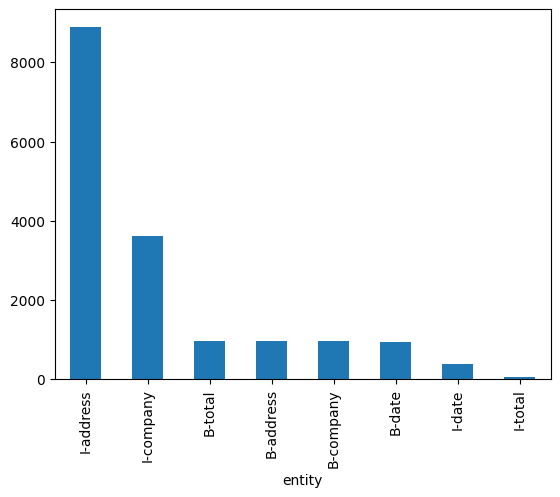

In [38]:
check_entities(bio_df)

In [39]:
# Filtrer pour obtenir uniquement les lignes 'I-total'
i_total_rows = bio_df[bio_df['entity'] == 'I-total']

# Identifier les duplicatas basés sur 'doc', 'value', 'entity'
duplicated_i_total = i_total_rows.duplicated(subset=['doc', 'value', 'entity'], keep=False)

# Obtenir les indices des duplicatas dans le DataFrame filtré
duplicated_indices = i_total_rows[duplicated_i_total].index
# Supprimer les duplicatas identifiés
bio_df = bio_df.drop(duplicated_indices)

entity
I-address    8894
I-company    3618
B-total       966
B-address     965
B-company     961
B-date        940
I-date        375
I-total        17
Name: count, dtype: int64


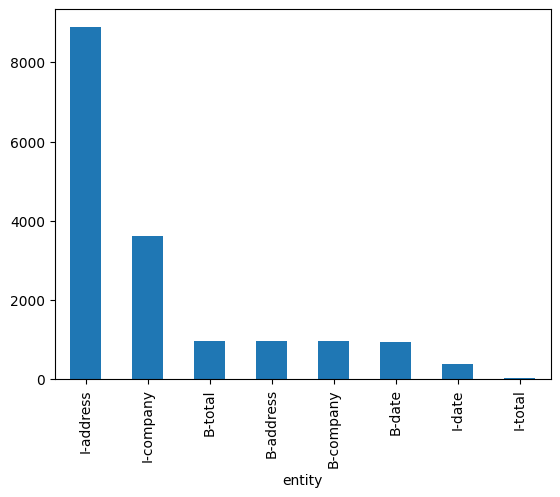

In [40]:
check_entities(bio_df)

In [41]:
bio_df[bio_df['entity'] == 'I-total']

,doc,line_id,value,entity
43792,X51006619341,21,8.60,I-total
43988,X51006619343,30,22.90,I-total
45347,X51006619709,54,57.40,I-total
45594,X51006619765,50,64.70,I-total
46690,X51006620186,45,68.10,I-total
47095,X51006620190,24,21.50,I-total
50910,X51007103599,25,9.00,I-total
51163,X51007103641,45,34.80,I-total
51295,X51007103643,45,34.80,I-total
81346,X51005715455,16,10.60,I-total


In [42]:
i_total_docs = bio_df[bio_df['entity'] == 'I-total']

In [43]:
for _, row in i_total_docs.iterrows():
    doc_id = row['doc']
    i_total_value = row['value']
    
    # Trouver les lignes 'B-total' dans le même document
    b_total_rows = bio_df[(bio_df['doc'] == doc_id) & (bio_df['entity'] == 'B-total')]
    
    for idx, b_row in b_total_rows.iterrows():
        # Convertir la valeur en numérique avec 'coerce' pour gérer les non-conversions
        numeric_value = pd.to_numeric(b_row['value'], errors='coerce')
        
        # Vérifier si le résultat est NaN pour déterminer si la conversion a échoué (la valeur n'était pas numérique)
        if np.isnan(numeric_value):
            # Remplacer la valeur 'B-total' par celle de 'I-total'
            bio_df.at[idx, 'value'] = i_total_value

In [44]:
def drop_b_i_total_duplicates(bio_df):
    # Étape 1: Obtenir les combinaisons uniques de `doc` et `value` pour 'B-total'
    b_totals = bio_df[bio_df['entity'] == 'B-total'][['doc', 'value']].drop_duplicates()

    # Étape 2: Identifier les 'I-total' à supprimer
    # Cela se fait en cherchant une correspondance dans 'b_totals'
    i_totals_to_drop = bio_df[(bio_df['entity'] == 'I-total') & 
                              bio_df[['doc', 'value']].isin(b_totals.to_dict('list')).all(axis=1)]
    
    # Étape 3: Supprimer ces 'I-total' du DataFrame
    bio_df_cleaned = bio_df.drop(i_totals_to_drop.index)

    return bio_df_cleaned
bio_df=drop_b_i_total_duplicates(bio_df)

entity
I-address    8894
I-company    3618
B-total       966
B-address     965
B-company     961
B-date        940
I-date        375
Name: count, dtype: int64


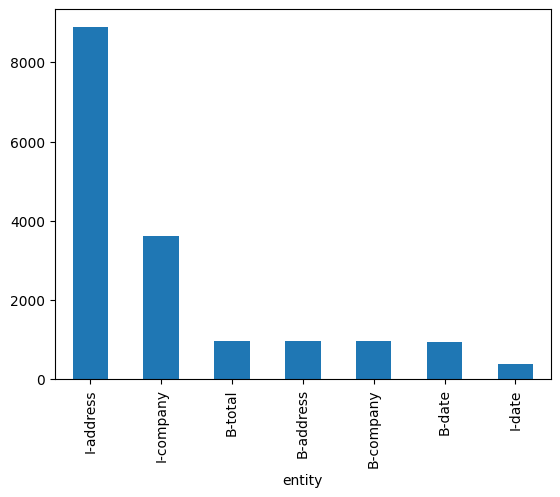

In [45]:
check_entities(bio_df)

## Date 

In [46]:
def get_b_date_and_i_date(bio_df):
    # Filtrer pour obtenir uniquement les lignes où 'entity' est 'I-date' ou 'B-date'
    date_entities = bio_df[bio_df['entity'].isin(['I-date', 'B-date'])]

    # Optionnellement, trier par 'doc' pour regrouper les entités par document
    date_entities_sorted = date_entities.sort_values(by=['doc'])
    return date_entities_sorted

date_entities_sorted=get_b_date_and_i_date(bio_df)
date_entities_sorted

,doc,line_id,value,entity
28,X00016469612,10,25/12/2018,B-date
103,X00016469619,9,19/10/2018,B-date
283,X00016469620,49,12-01-19,B-date
331,X00016469622,13,25/12/2018,B-date
530,X00016469623,56,18-11-18,B-date
...,...,...,...,...
110539,X51009447842,8,14/03/2018,B-date
110639,X51009453729,10,27/03/2018,B-date
70900,X51009453801,13,20/03/2018,B-date
70990,X51009453804,10,27/03/2018,B-date


In [47]:
def drop_duplicates_dates_and_keep_b(bio_df):
    b_totals = bio_df[bio_df['entity'] == 'B-date'][['doc', 'value']].drop_duplicates()

    # Étape 2: Identifier les 'I-total' à supprimer
    # Cela se fait en cherchant une correspondance dans 'b_totals'
    i_totals_to_drop = bio_df[(bio_df['entity'] == 'I-date') & 
                              bio_df[['doc', 'value']].isin(b_totals.to_dict('list')).all(axis=1)]
    
    # Étape 3: Supprimer ces 'I-total' du DataFrame
    bio_df= bio_df.drop(i_totals_to_drop.index)
    
    return bio_df
bio_df=drop_duplicates_dates_and_keep_b(bio_df)

In [48]:
date_entities_sorted_1=get_b_date_and_i_date(bio_df)
date_entities_sorted_1

,doc,line_id,value,entity
28,X00016469612,10,25/12/2018,B-date
103,X00016469619,9,19/10/2018,B-date
283,X00016469620,49,12-01-19,B-date
331,X00016469622,13,25/12/2018,B-date
530,X00016469623,56,18-11-18,B-date
...,...,...,...,...
110539,X51009447842,8,14/03/2018,B-date
110639,X51009453729,10,27/03/2018,B-date
70900,X51009453801,13,20/03/2018,B-date
70990,X51009453804,10,27/03/2018,B-date


entity
I-address    8894
I-company    3618
B-total       966
B-address     965
B-company     961
B-date        940
I-date        151
Name: count, dtype: int64


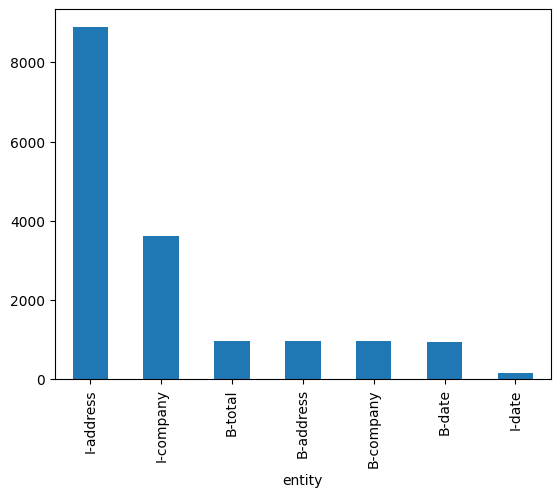

In [49]:
check_entities(bio_df)

quels documents n'ont pas de B_date?

In [50]:
# Étape 1: Trouver tous les documents uniques
all_docs = set(bio_df['doc'].unique())

# Étape 2: Trouver les documents qui contiennent au moins une 'B-date'
docs_with_b_date = set(bio_df[bio_df['entity'] == 'B-date']['doc'].unique())

# Étape 3: Identifier les documents sans 'B-date'
docs_without_b_date = all_docs - docs_with_b_date

# Afficher les documents sans 'B-date'
print("Documents sans 'B-date':", docs_without_b_date)

Documents sans 'B-date': {'X51005200931', 'X51006389894', 'X51006414674', 'X51006679216', 'X51006335547', 'X51006414519', 'X51005719917', 'X51006466055', 'X51005749912', 'X51006619869', 'X51006388081', 'X51005724552', 'X51005230621', 'X51006620192', 'X51005719874', 'X51006414675', 'X51006327960', 'X51008142038', 'X51006619545', 'X51005447850', 'X51006913074', 'X51005568887', 'X51005587261', 'X51005719902', 'X51006328345', 'X51006401869'}


In [51]:
len(docs_without_b_date)

26

drop toutes les documents qui n'ont pa sde dates 

In [52]:
bio_df= bio_df[~bio_df['doc'].isin(docs_without_b_date)]

entity
I-address    8596
I-company    3534
B-date        940
B-total       940
B-address     939
B-company     935
I-date        151
Name: count, dtype: int64


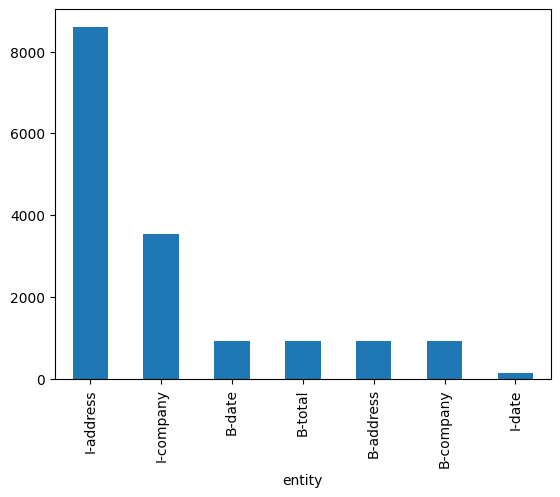

In [53]:
check_entities(bio_df)

## Adress

adresses avec des O au milieu

In [54]:
docs_with_o_in_address = set()
for doc in bio_df['doc'].unique():
    doc_df = bio_df[bio_df['doc'] == doc]
    prev_entity = ""
    for i, row in doc_df.iterrows():
        if prev_entity == 'B-address' and row['entity'] == 'O':
            # Vérifier si le prochain non 'O' est un 'I-address'
            next_rows = doc_df[(doc_df['line_id'] > row['line_id']) & (doc_df['entity'] != 'O')]
            if not next_rows.empty and next_rows.iloc[0]['entity'].startswith('I-address'):
                docs_with_o_in_address.add(doc)
                break  # Arrêtez de chercher dans ce document après avoir trouvé une séquence
        prev_entity = row['entity'] if row['entity'] != 'O' else prev_entity

# Afficher les résultats
print(f"Documents avec 'O' au milieu d'une séquence d'adresse: {len(docs_with_o_in_address)}")

Documents avec 'O' au milieu d'une séquence d'adresse: 36


In [55]:
def update_o_to_i_address_in_sequence(bio_df):
    docs = bio_df['doc'].unique()  # Obtenir tous les documents uniques
    for doc in docs:
        doc_df = bio_df[bio_df['doc'] == doc]  # Filtrer par document
        indexes = doc_df.index
        for i in range(len(indexes)):
            if doc_df.loc[indexes[i], 'entity'] == 'B-address':
                # Trouver la prochaine entité qui n'est pas 'O' après un 'B-address'
                for j in range(i + 1, len(indexes)):
                    if doc_df.loc[indexes[j], 'entity'] == 'O':
                        # Marquer l'index si c'est 'O'
                        bio_df.loc[indexes[j], 'temp_mark'] = True
                    elif doc_df.loc[indexes[j], 'entity'].startswith('I-address'):
                        # Si on trouve 'I-address' après 'O', mettre à jour tous les 'O' marqués en 'I-address'
                        bio_df.loc[indexes[i:j], 'entity'] = bio_df.loc[indexes[i:j], 'entity'].apply(lambda x: 'I-address' if x == 'O' else x)
                        bio_df.drop(columns=['temp_mark'], inplace=True, errors='ignore')  # Nettoyer la colonne temporaire
                        break  # Sortir de la boucle interne une fois la mise à jour effectuée
                    else:
                        # Si une autre entité est trouvée, réinitialiser les marques et sortir de la boucle
                        bio_df.drop(columns=['temp_mark'], inplace=True, errors='ignore')  # Nettoyer la colonne temporaire
                        break

    return bio_df

# Appliquer la fonction pour mettre à jour les 'O' en 'I-address' dans les séquences d'adresse
bio_df = update_o_to_i_address_in_sequence(bio_df)
bio_df

/tmp/ipykernel_14117/1002020370.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bio_df.loc[indexes[j], 'temp_mark'] = True
/tmp/ipykernel_14117/1002020370.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bio_df.loc[indexes[j], 'temp_mark'] = True
/tmp/ipykernel_14117/1002020370.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bio_df.loc[indexes[j], 'temp_mark'] = True
/tmp/ipykernel_14117/1002020370.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company
...,...,...,...,...
111120,X51008099100,7,0,O
111121,X51008099100,7,0,O
111122,X51008099100,7,0,O
111123,X51009447842,14,AMT,O


entity
I-address    8653
I-company    3534
B-date        940
B-total       940
B-address     939
B-company     935
I-date        151
Name: count, dtype: int64


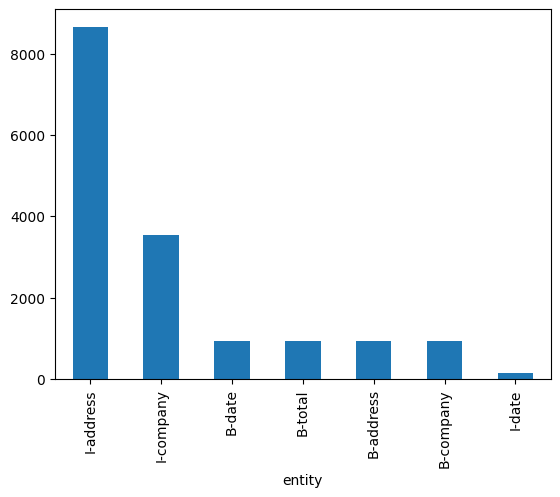

In [56]:
check_entities(bio_df)

est ce qu'il y a plusieur groupes de b adress dans un même document ?

In [57]:
# Initialiser un dictionnaire pour conserver le compte des 'B-address' par document
b_address_counts = {}

# Grouper le DataFrame par 'doc' et itérer sur chaque groupe
for doc, group in bio_df.groupby('doc'):
    # Compter le nombre de 'B-address' dans ce document
    b_address_count = (group['entity'] == 'B-address').sum()
    # Stocker le compte dans le dictionnaire
    b_address_counts[doc] = b_address_count

# Identifier les documents avec plusieurs 'B-address'
docs_with_multiple_b_address = {doc: count for doc, count in b_address_counts.items() if count > 1}

print("Documents avec plusieurs 'B-address':", docs_with_multiple_b_address)

Documents avec plusieurs 'B-address': {}


entity
I-address    8653
I-company    3534
B-date        940
B-total       940
B-address     939
B-company     935
I-date        151
Name: count, dtype: int64


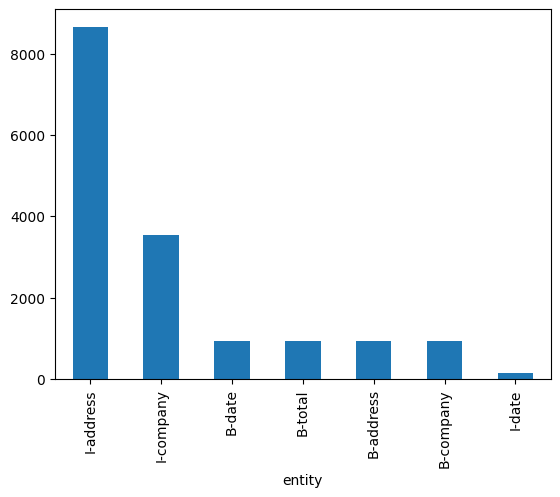

In [58]:
check_entities(bio_df)

## Compagny 

compagny avec des O au  mileu dans un doc

In [59]:
docs_with_o_in_compagny = set()
for doc in bio_df['doc'].unique():
    doc_df = bio_df[bio_df['doc'] == doc]
    prev_entity = ""
    for i, row in doc_df.iterrows():
        if prev_entity == 'B-compagny' and row['entity'] == 'O':
           
            next_rows = doc_df[(doc_df['line_id'] > row['line_id']) & (doc_df['entity'] != 'O')]
            if not next_rows.empty and next_rows.iloc[0]['entity'].startswith('I-compagny'):
                docs_with_o_in_compagny.add(doc)
                break  # Arrêtez de chercher dans ce document après avoir trouvé une séquence
        prev_entity = row['entity'] if row['entity'] != 'O' else prev_entity

# Afficher les résultats
print(f"Documents avec 'O' au milieu d'une séquence d'adresse: {len(docs_with_o_in_compagny)}")

Documents avec 'O' au milieu d'une séquence d'adresse: 0


est ce qu'il y a plusieur groupes de b compagny dans un même document ?

In [60]:
b_address_counts = {}

# Grouper le DataFrame par 'doc' et itérer sur chaque groupe
for doc, group in bio_df.groupby('doc'):
    # Compter le nombre de 'B-address' dans ce document
    b_address_count = (group['entity'] == 'B-compagny').sum()
    # Stocker le compte dans le dictionnaire
    b_address_counts[doc] = b_address_count

# Identifier les documents avec plusieurs 'B-address'
docs_with_multiple_b_address = {doc: count for doc, count in b_address_counts.items() if count > 1}

print("Documents avec plusieurs 'B-compagny':", docs_with_multiple_b_address)

Documents avec plusieurs 'B-compagny': {}


drop les documents qui n'ont pas de B-compagny

In [61]:
docs_with_b_company = set(bio_df[bio_df['entity'] == 'B-company']['doc'].unique())
# Filtrer le DataFrame pour inclure seulement les lignes des documents avec 'B-company'
bio_df = bio_df[bio_df['doc'].isin(docs_with_b_company)]

regarder le doc qui n'a pas de compagny et d'adress

In [62]:
# Identifier les documents qui contiennent des entités d'adresse ('B-address' ou 'I-address')
docs_with_address = set(bio_df[bio_df['entity'].isin(['B-address', 'I-address'])]['doc'].unique())
# Trouver tous les documents uniques dans le DataFrame
all_docs = set(bio_df['doc'].unique())

# Identifier les documents sans entités d'adresse
docs_without_address = all_docs - docs_with_address

# Afficher les documents sans entités d'adresse
print("Documents sans entités d'adresse:", docs_without_address)

Documents sans entités d'adresse: {'X51005663280'}


le drop

In [63]:
# Filtrer le DataFrame pour exclure les lignes où 'doc' est 'X51005663280'
bio_df = bio_df[bio_df['doc'] != 'X51005663280']

entity
I-address    8610
I-company    3531
B-company     934
B-address     934
B-date        934
B-total       934
I-date        149
Name: count, dtype: int64


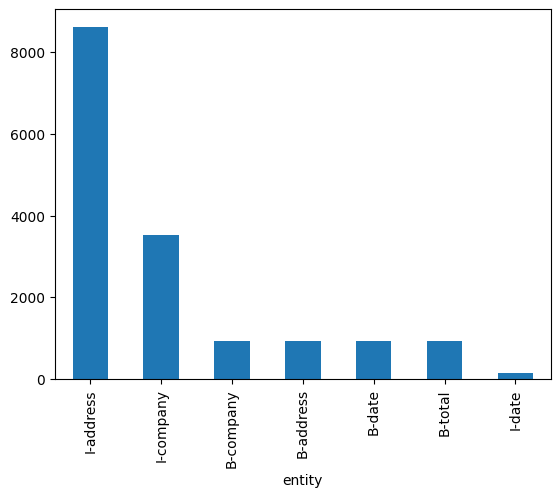

In [64]:
check_entities(bio_df)

# Save df 

In [65]:
bio_df.to_csv('/home/e077926/buscode_2023/05_E2_tata/data/cleaned_raw_bbox_df.csv')